#installing dependencies

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon Dec 26 20:25:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook works fine with transformers 4.12, it is not tested on newer versions

In [4]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 32.5 MB/s 
     |████████████████████████████████| 880 kB 65.5 MB/s 
     |████████████████████████████████| 3.3 MB 61.4 MB/s 
     |████████████████████████████████| 182 kB 81.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b6e87afe43a9cc54e9b54c9aae3a8f0f8456af7417efd74bb1535fb7240c564d
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 33.3 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remo

Let's download some Arabic text classification datasets

#Trainer

Start the training procedure

In [5]:
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [7]:
from sklearn import model_selection
##############For Training Data#####################
# Read the data from the csv file named 'preprocessedData.csv' arabic data
train1 = pd.read_csv('./cleaned_train.csv', encoding='utf-8')
train2 = pd.read_csv('./cleaned_dev.csv', encoding='utf-8')

train = pd.concat([train1, train2], ignore_index=True)


# Split the data into train and test
train, test = model_selection.train_test_split(train, test_size=0.01)
# Unpack the data into text and stance
Train_X = train['text']
stance_Train_Y = train['stance']
cat_Train_Y = train['category']

# Unpack the data into text, and stance
Test_X = test['text']
stance_Test_Y = test['stance']
cat_Test_Y = test['category']


In [8]:
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

Create and apply preprocessing using the AraBERT processor

In [9]:
arabic_prep = ArabertPreprocessor(model_name)
Train_X = Train_X.apply(lambda x: arabic_prep.preprocess(x))
Test_X = Test_X.apply(lambda x: arabic_prep.preprocess(x))  

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [10]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


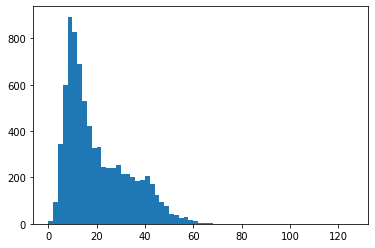

Testing Sentence Lengths: 


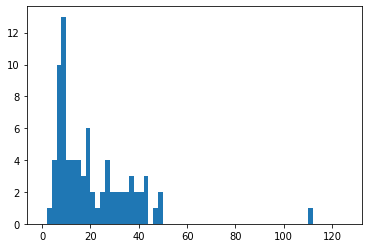

In [11]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in Train_X.to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in Test_X.to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [12]:
max_len = 120
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in Test_X.to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in Test_X.to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [13]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [14]:
label_map = { v:index for index, v in enumerate([-1,0,1]) }
print(label_map)

train_dataset = ClassificationDataset(
    Train_X.to_list(),
    stance_Train_Y.to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    Test_X.to_list(),
    stance_Test_Y.to_list(),
    model_name,
    max_len,
    label_map
  )

{-1: 0, 0: 1, 1: 2}


Check the dataset output

In [15]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 3866, 3902, 51321, 22729, 40204, 1428, 34495, 28770, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Create a function that return a pretrained model ready to do classification

In [16]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [17]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [18]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [19]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [20]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [21]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 7908
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 494


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.377718,0.585561,0.862500
1,No log,0.360710,0.622862,0.862500


***** Running Evaluation *****
  Num examples = 80
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-247
Configuration saved in ./train/checkpoint-247/config.json
Model weights saved in ./train/checkpoint-247/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 80
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-494
Configuration saved in ./train/checkpoint-494/config.json
Model weights saved in ./train/checkpoint-494/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-494 (score: 0.6228617106314949).


TrainOutput(global_step=494, training_loss=0.4161912246271666, metrics={'train_runtime': 357.726, 'train_samples_per_second': 44.213, 'train_steps_per_second': 1.381, 'total_flos': 975081881511360.0, 'train_loss': 0.4161912246271666, 'epoch': 2.0})

Save the model, the tokenizer and the config

In [22]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: -1, 1: 0, 2: 1}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [28]:
#copy the model to drive
!cp -r output_dir /content/drive/MyDrive

## predict using the saved model

In [24]:
from transformers import pipeline

In [25]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

loading configuration file output_dir/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": -1,
    "1": 0,
    "2": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "-1": 0,
    "0": 1,
    "1": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file output_dir/config.json
Model config

In [31]:
pipe("Some Text", "Some")

Ignoring args : ('Some',)
/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[[{'label': -1, 'score': 0.010384682565927505},
  {'label': 0, 'score': 0.24830502271652222},
  {'label': 1, 'score': 0.7413102984428406}]]

In [29]:
import csv

dataframe = pd.DataFrame

Test_Data = pd.read_csv('cleaned_test_farasa.csv', encoding='utf-8')
fields = ['id','stance']

data_frame = pd.DataFrame(columns=fields)

for i in range(len(Test_Data)):

  id = Test_Data['id'][i]
  text = Test_Data['text'][i]

  prediction_list_dict = pipe(text)[0]
  # [{'label': -1, 'score': 0.32171744108200073}]

  final_label = -10
  final_score = -1

  for label_score in prediction_list_dict:
    label = label_score['label']
    score = label_score['score']
    if score > final_score:
      final_score = score 
      final_label = label
  data_frame = data_frame.append({'id': id, 'stance': final_label}, ignore_index=True)




/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [30]:
data_frame

,id,stance
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
1995,1995,1
1996,1996,1
1997,1997,1
1998,1998,0


In [32]:
data_frame.to_csv("results_stance.csv",index=False)